In [265]:
# Puzzle Piece Feature Extraction and Matching - Debug Notebook
# ================================================================
# This notebook helps debug the puzzle piece matching algorithm

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.spatial import distance
import random
from scipy import ndimage
from scipy.spatial.distance import cosine

# Configuration
IMAGE_DIR = "../data/images"
PROVIDED_MASKS_DIR = "../data/masks"
PREDICTED_MASKS_DIR = "../output/predicted_masks"

## 1. Load and Inspect Pieces + Masks

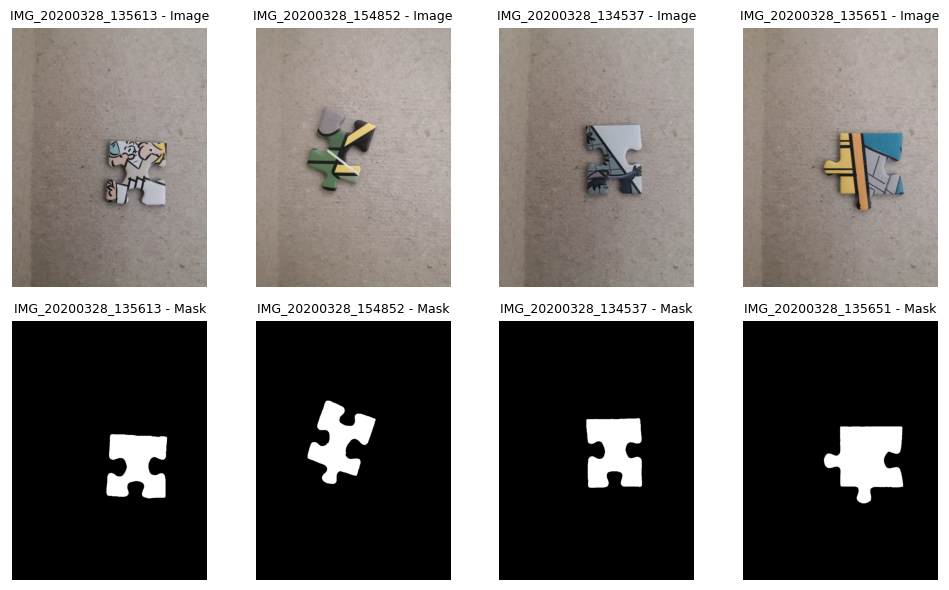

In [231]:
def load_piece(piece_id, scale=0.25):
    """Load image and mask for a single piece"""
    img_path = Path(IMAGE_DIR) / f"{piece_id}.jpg"
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Try provided mask first
    mask_path = Path(PROVIDED_MASKS_DIR) / f"{piece_id}_mask.png"
    if not mask_path.exists():
        mask_path = Path(PREDICTED_MASKS_DIR) / f"{piece_id}_mask.png"
    
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # ---- Downscale both image and mask ----
    if scale != 1.0:
        new_size = (int(img.shape[1] * scale), int(img.shape[0] * scale))
        img_rgb = cv2.resize(img_rgb, new_size, interpolation=cv2.INTER_AREA)
        binary = cv2.resize(binary, new_size, interpolation=cv2.INTER_NEAREST)
    
    return img_rgb, binary

all_images = sorted(list(Path(IMAGE_DIR).glob("*.jpg")))
sample_ids = random.sample([p.stem for p in all_images], 4)

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.flatten()

for i, piece_id in enumerate(sample_ids):
    img, mask = load_piece(piece_id)
    
    axes[i].imshow(img)
    axes[i].set_title(f"{piece_id} - Image", fontsize=9)
    axes[i].axis('off')

    axes[i + 4].imshow(mask, cmap='gray')
    axes[i + 4].set_title(f"{piece_id} - Mask", fontsize=9)
    axes[i + 4].axis('off')

plt.tight_layout()
plt.show()

## 2. Extract Contours and Corners

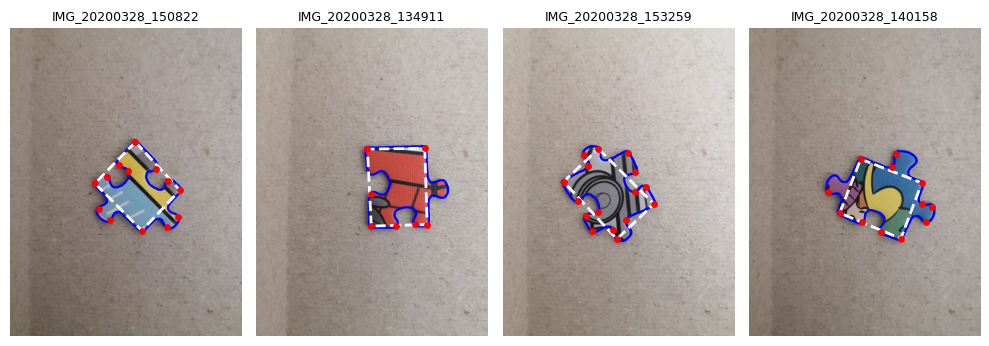

In [232]:
def harris_corners_from_mask(mask, block_size=20, ksize=7, k=0.08, neighborhood_size=70, score_threshold=0.3, minmax_percentile=40):
    """
    Detect candidate corners using Harris detector on a mask.
    Returns an array of (x, y) corner coordinates.
    """
    mask_float = np.float32(mask)
    harris = cv2.cornerHarris(mask_float, blockSize=block_size, ksize=ksize, k=k)
    harris = harris * (mask_float > 0) # weight by mask and zero any responses outside the mask

    # Normalize Harris response to 0..1
    data = harris.copy()
    data -= data.min()
    if data.max() > 0:
        data /= data.max()

    # Threshold by score
    data[data < score_threshold] = 0.

    # Local maxima
    data_max = ndimage.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)

    # Local min & percentile-based contrast threshold
    data_min = ndimage.minimum_filter(data, neighborhood_size)
    diff = data_max - data_min
    threshold_value = np.percentile(diff[diff > 0], minmax_percentile)
    maxima[diff < threshold_value] = 0

    # Connected components → center of mass
    labeled, num_objects = ndimage.label(maxima)
    if num_objects == 0:
        return np.empty((0, 2), dtype=int)
    yx = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects + 1)))
    return yx[:, ::-1].astype(int)  # (x, y)

def extract_largest_contour(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None
    contour = max(contours, key=cv2.contourArea).squeeze()

    oriented_area = cv2.contourArea(contour, oriented=True)
    
    if oriented_area < 0:
        return contour[::-1].copy()  # Reverse contour if counter-clockwise
    
    return contour.copy()

def get_best_fitting_rect_coords(xy, d_threshold=30, perp_angle_thresh=14):
    import scipy.spatial
    import scipy.stats
    N = len(xy)
    if N < 4:
        return None

    distances = scipy.spatial.distance.cdist(xy, xy)
    distances[distances < d_threshold] = 0

    def compute_angles(xy):
        angles = np.zeros((N, N))
        for i in range(N):
            for j in range(i + 1, N):
                dx = xy[j, 0] - xy[i, 0]
                dy = xy[j, 1] - xy[i, 1]
                angle = np.degrees(np.arctan2(dy, dx)) if dx != 0 else 90
                angles[i, j] = angles[j, i] = angle
        return angles

    angles = compute_angles(xy)
    possible_rectangles = []

    def search(idx, prev_points=[]):
        depth = len(prev_points)
        curr_point = xy[idx]

        if depth == 0:
            right_points_idx = np.nonzero(np.logical_and(xy[:, 0] > curr_point[0], distances[idx] > 0))[0]
            for next_idx in right_points_idx:
                search(next_idx, [idx])
            return

        if depth in (1, 2):
            last_angle = angles[idx, prev_points[-1]]
            perp_angle = (last_angle - 90) % 180
            valid_next = np.nonzero(np.logical_and(distances[idx] > 0,
                                                   np.abs(angles[idx] - perp_angle) <= perp_angle_thresh))[0]
            for next_idx in valid_next:
                if next_idx not in prev_points:
                    search(next_idx, prev_points + [idx])

        if depth == 3:
            last_angle = angles[idx, prev_points[-1]]
            perp_angle = (last_angle - 90) % 180
            if distances[idx, prev_points[0]] > 0 and abs(angles[idx, prev_points[0]] - perp_angle) <= perp_angle_thresh:
                rect_points = prev_points + [idx]
                if not any(set(rect_points) == set(r) for r in possible_rectangles):
                    possible_rectangles.append(rect_points)

    for i in range(N):
        search(i)

    if not possible_rectangles:
        return None

    def poly_area(pts):
        x, y = pts[:, 0], pts[:, 1]
        return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

    scores = []
    for rect in possible_rectangles:
        pts = xy[rect]
        area = poly_area(pts)
        mse = sum((abs(angles[rect[i], rect[(i + 1) % 4]] - angles[rect[(i + 1) % 4], rect[(i + 2) % 4]]) - 90) ** 2
                  for i in range(4))
        scores.append(area * scipy.stats.norm(0, 150).pdf(mse))

    best_rect_idx = possible_rectangles[np.argmax(scores)]
    return xy[best_rect_idx]

def extract_contour_and_candidate_corners(mask):
    """
    Returns the largest contour and Harris-detected corners of a mask,
    plus the best-fitting rectangle from candidate corners.
    """
    contour = extract_largest_contour(mask)
    if contour is None:
        return None, None, None

    corners = harris_corners_from_mask(mask)

    if corners.shape[0] >= 4:
        try:
            best_rect = get_best_fitting_rect_coords(corners)
        except:
            best_rect = None
    else:
        best_rect = None

    return contour, corners, best_rect

def extract_contour_and_corners(mask, epsilon_factor=0.02):
    """
    Extracts the largest contour and the best 4 corners from the mask.
    """
    contour = extract_largest_contour(mask)

    corners = harris_corners_from_mask(mask)

    best_rect = None
    if corners.shape[0] >= 4:
        try:
            best_rect = get_best_fitting_rect_coords(corners)
        except Exception:
            best_rect = None

    # --- Fallback to contour polygon approximation ---
    if best_rect is None or len(best_rect) != 4:
        peri = cv2.arcLength(contour.astype(np.float32), True)
        approx = cv2.approxPolyDP(contour.astype(np.float32), epsilon_factor * peri, True)
        approx = approx.reshape(-1, 2)

        # If not exactly 4 points, choose 4 most distant points
        if len(approx) != 4:
            from scipy.spatial import ConvexHull
            hull = ConvexHull(approx)
            pts = approx[hull.vertices]
            if len(pts) > 4:
                # Pick 4 corners spread across the hull
                idxs = np.linspace(0, len(pts) - 1, 4, dtype=int)
                best_rect = pts[idxs]
            else:
                best_rect = pts
        else:
            best_rect = approx

    return contour, best_rect

sample_ids = random.sample([p.stem for p in all_images], 4)

fig, axes = plt.subplots(1, 4, figsize=(10, 4))
axes = axes.flatten()

for i, piece_id in enumerate(sample_ids):
    img, mask = load_piece(piece_id)
    contour, corners, best_rect = extract_contour_and_candidate_corners(mask)
    
    axes[i].imshow(img)
    if contour is not None and corners is not None:
        axes[i].plot(contour[:, 0], contour[:, 1], 'b-', linewidth=1.5)
        axes[i].scatter(corners[:, 0], corners[:, 1], c='red', s=15, zorder=5)

    if best_rect is not None:
        axes[i].plot(*np.vstack([best_rect, best_rect[0]]).T, 'w--', linewidth=2)

    axes[i].set_title(piece_id, fontsize=9)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 3. Extract and Visualize Sides

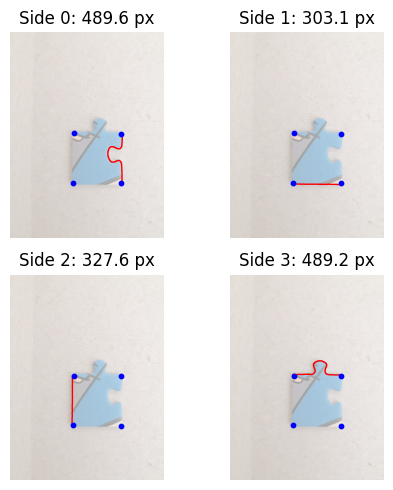

In [237]:
def extract_sides(contour, corners):
    """Extract four side contours using corner points."""
    # Find nearest contour points to corners
    corner_indices = []
    for corner in corners:
        dists = np.linalg.norm(contour - corner, axis=-1)
        corner_indices.append(np.argmin(dists))
    
    corner_indices = sorted(corner_indices)
    
    # Extract sides between consecutive corners
    sides = []
    for a in range(4):
        i, j = corner_indices[a], corner_indices[(a+1) % 4]
        rolled_contour = np.roll(contour, -i, axis=0)
        segment_length = (j - i + 1) % len(contour)
        if segment_length == 0:
            segment_length = len(contour)
        side_contour = rolled_contour[:segment_length]
        sides.append(side_contour)
    
    return sides

sample_piece_id = all_images[0].stem
img, mask = load_piece(sample_piece_id)
contour, corners = extract_contour_and_corners(mask)

sides = extract_sides(contour, corners)

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes = axes.flatten()

for i, side in enumerate(sides):
    ax = axes[i]
    
    # Calculate total pixel length along the side
    side_len = np.sum(np.linalg.norm(np.diff(side, axis=0), axis=1))
    
    # Overlay original image lightly
    ax.imshow(img, alpha=0.4)
    
    # Plot side in red
    ax.plot(side[:, 0], side[:, 1], 'r-', linewidth=1)
    
    # Mark all corners
    ax.scatter(corners[:, 0], corners[:, 1], c='blue', s=10, zorder=5)
    
    ax.set_title(f"Side {i}: {side_len:.1f} px")
    ax.axis('off')

plt.tight_layout()
plt.show()

## 4. Normalize Sides (Geometry + Color)

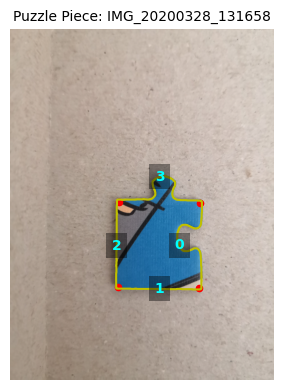

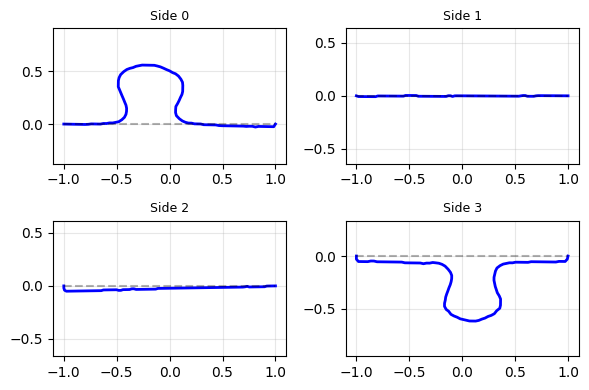

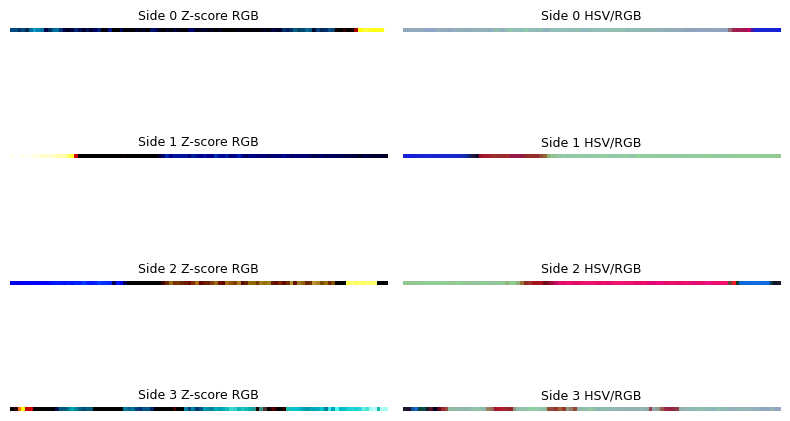

In [318]:
def normalize_side_with_color(side, img_rgb, mask, offset_inward=15, num_points=100):
    """
    Normalize puzzle side geometry and sample colors slightly inside the piece.
    """
    side = side.copy().astype(np.float64)
    
    # --- Compute inward normals ---
    tangents = np.gradient(side, axis=0)
    tangents /= np.linalg.norm(tangents, axis=1, keepdims=True) + 1e-8
    normals = np.column_stack([-tangents[:, 1], tangents[:, 0]])

    # --- Ensure normals point inward using mask ---
    if mask is not None:
        mid_idx = len(side) // 2
        test_pt = side[mid_idx] + normals[mid_idx] * offset_inward
        x, y = int(test_pt[0]), int(test_pt[1])
        if not (0 <= y < mask.shape[0] and 0 <= x < mask.shape[1] and mask[y, x] > 0):
            normals = -normals

    inner_side = side + offset_inward * normals

    # --- Sample colors ---
    colors = []
    for pt in inner_side:
        x, y = int(pt[0]), int(pt[1])
        if 0 <= y < img_rgb.shape[0] and 0 <= x < img_rgb.shape[1]:
            colors.append(img_rgb[y, x])
        else:
            colors.append([0, 0, 0])
    colors = np.array(colors, dtype=np.float32)

    # --- Z-score normalization ---
    mean = np.mean(colors, axis=0, keepdims=True)
    std = np.std(colors, axis=0, keepdims=True) + 1e-6
    colors_zscore = (colors - mean) / std

    # --- Convert to HSV ---
    colors_hsv = cv2.cvtColor(colors.astype(np.uint8).reshape(1, -1, 3), cv2.COLOR_RGB2HSV).reshape(-1, 3).astype(np.float32)
    colors_hsv[:, 0] /= 179.0
    colors_hsv[:, 1:] /= 255.0

    # --- Normalize geometry ---
    first_point, last_point = side[0], side[-1]
    baseline_center = (first_point + last_point) / 2
    side_translated = side - baseline_center
    baseline_vector = last_point - first_point
    baseline_length = np.linalg.norm(baseline_vector)
    side_scaled = side_translated * (2.0 / baseline_length)
    theta = -np.arctan2(baseline_vector[1], baseline_vector[0])
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    side_rotated = side_scaled @ rotation_matrix.T

    if side_rotated[0, 0] > side_rotated[-1, 0]:
        side_rotated = side_rotated[::-1]
        colors_zscore = colors_zscore[::-1]
        colors_hsv = colors_hsv[::-1]

    # --- Interpolate geometry ---
    t_original = np.linspace(0, 1, len(side_rotated))
    t_new = np.linspace(0, 1, num_points)
    interp_x = interp1d(t_original, side_rotated[:, 0], kind='linear')
    interp_y = interp1d(t_original, side_rotated[:, 1], kind='linear')
    normalized_side = np.column_stack([interp_x(t_new), interp_y(t_new)])

    # --- Interpolate colors ---
    interp_z = [interp1d(t_original, colors_zscore[:, i], kind='linear')(t_new) for i in range(3)]
    colors_zscore_interp = np.column_stack(interp_z)
    
    interp_other = [interp1d(t_original, colors_hsv[:, i], kind='linear')(t_new) for i in range(3)]
    colors_other_interp = np.column_stack(interp_other)

    # --- Combine Z-score with chosen color space ---
    colors_combined = np.hstack([colors_zscore_interp, colors_other_interp])

    return normalized_side, colors_combined

# --- Load sample piece ---
sample_piece_id = all_images[0].stem
img, mask = load_piece(sample_piece_id)
contour, corners = extract_contour_and_corners(mask)
sides = extract_sides(contour, corners)

normalized_sides = []
normalized_colors = []

for side in sides:
    norm_side, norm_colours = normalize_side_with_color(side, img, mask)
    normalized_sides.append(norm_side)
    normalized_colors.append(norm_colours)

# --- 1. Show the piece with numbered sides ---
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img)
ax.set_title(f"Puzzle Piece: {sample_piece_id}", fontsize=10)
ax.axis('off')
ax.plot(contour[:, 0], contour[:, 1], 'y-', linewidth=1.5)
ax.scatter(corners[:, 0], corners[:, 1], color='red', s=20)
for i, side in enumerate(sides):
    mid_idx = len(side) // 2
    mid_pt = side[mid_idx]
    ax.text(mid_pt[0], mid_pt[1], str(i), color='cyan', fontsize=10, fontweight='bold',
            ha='center', va='center', bbox=dict(facecolor='black', alpha=0.4, lw=0))

plt.tight_layout()
plt.show()

# --- 2. Show normalized side geometries ---
fig, axes = plt.subplots(2, 2, figsize=(6, 4))
axes = axes.flatten()
for i, norm_side in enumerate(normalized_sides):
    ax = axes[i]
    ax.plot(norm_side[:, 0], norm_side[:, 1], 'b-', linewidth=2)
    ax.plot([norm_side[0, 0], norm_side[-1, 0]],
            [norm_side[0, 1], norm_side[-1, 1]], 'k--', alpha=0.3)
    ax.set_title(f"Side {i}", fontsize=9)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 3. Show color strips ---
num_sides = len(normalized_colors) 
fig, axes = plt.subplots(4, 2, figsize=(8, 6))

for i in range(4):
    # --- Z-score RGB (first 3 channels) ---
    color_z = normalized_colors[i][:, :3]  # Z-score RGB
    color_strip_z = np.clip(color_z, 0, 1).reshape(1, -1, 3)

    axes[i, 0].imshow(color_strip_z)
    axes[i, 0].set_title(f"Side {i} Z-score RGB", fontsize=9)
    axes[i, 0].axis('off')

    # --- HSV (last 3 channels) ---
    color_hsv = normalized_colors[i][:, 3:]  # HSV
    color_strip_hsv = color_hsv.reshape(1, -1, 3)

    axes[i, 1].imshow(color_strip_hsv)
    axes[i, 1].set_title(f"Side {i} HSV/RGB", fontsize=9)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## 5. Detect Piece (Interior/Edge/Corner) and Side Types (Flat/Protruding/Sunken)

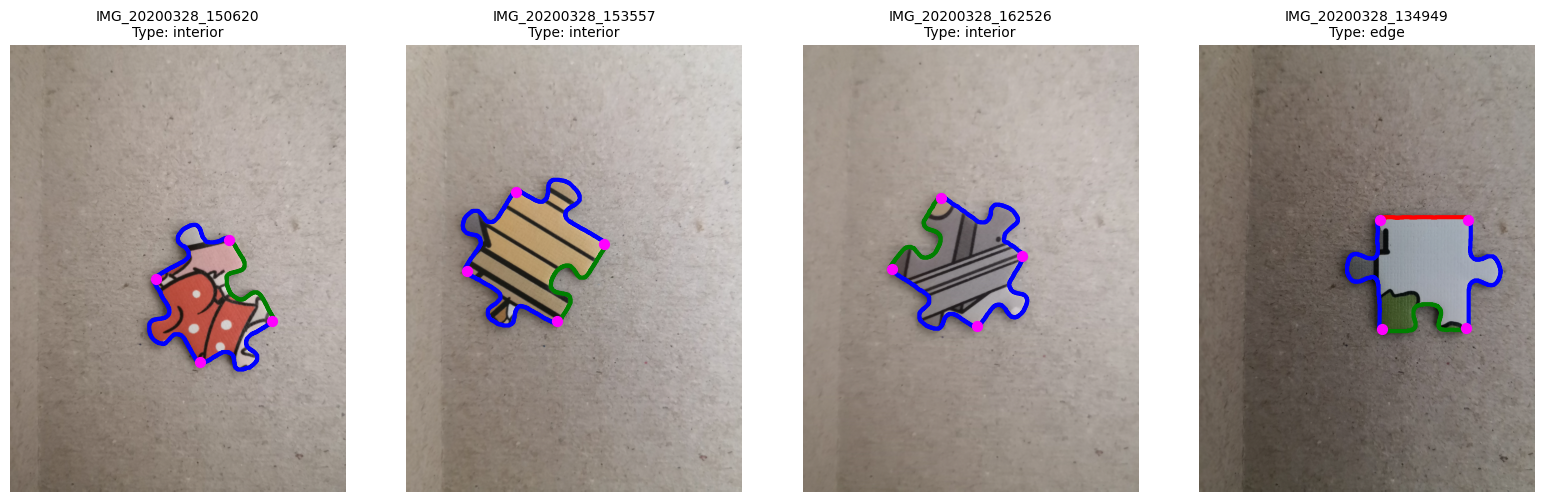

In [ ]:
def classify_side(normalized_side):
    """Classify side as flat, protruding, or sunken using average deviation"""
    
    # Straightness in normalized coordinates
    start = normalized_side[0]
    end = normalized_side[-1]
    line_points = np.linspace(start, end, len(normalized_side))
    deviations = normalized_side - line_points
    norm_devs = np.linalg.norm(deviations, axis=1)
    max_dev = np.max(norm_devs)
    is_straight = max_dev < 0.1
    
    # print(f"Normalized deviation: max={max_dev:.4f}, is_straight={is_straight}")
    
    if is_straight:
        return 'flat'
    
    # Use y-coordinates of deviations (since normalized always has sunken up)
    signed_devs = normalized_side[:, 1] - line_points[:, 1]
    avg_dev = np.mean(signed_devs)
    
    # print(f"Normalized side average signed deviation (y-axis): {avg_dev:.4f}")
    
    if avg_dev > 0:
        return 'sunken'  # deviation is upwards → sunken
    else:
        return 'protruding'  # deviation is downwards → protruding

sample_ids = random.sample([p.stem for p in all_images], 4)

fig, axes = plt.subplots(1, len(sample_ids), figsize=(16, 5))
axes = axes.flatten()

for i, piece_id in enumerate(sample_ids):
    img, mask = load_piece(piece_id)
    contour, corners = extract_contour_and_corners(mask)
    sides = extract_sides(contour, corners)
    normalized_sides = [normalize_side_with_color(s, img, mask)[0] for s in sides]
    
    side_types = []

    for norm_side in normalized_sides:
        stype = classify_side(norm_side)
        side_types.append(stype)

    # Determine piece type
    num_flat = side_types.count('flat')
    if num_flat == 0:
        piece_type = 'interior'
    elif num_flat == 1:
        piece_type = 'edge'
    elif num_flat == 2:
        flat_indices = [i for i, st in enumerate(side_types) if st == 'flat']
        diff = abs(flat_indices[0] - flat_indices[1])
        piece_type = 'corner' if (diff == 1 or diff == 3) else 'edge'
    else:
        piece_type = 'corner'
    
    ax = axes[i]
    ax.imshow(img)
    
    # Draw sides with color coding
    colors = {'flat': 'red', 'protruding': 'blue', 'sunken': 'green'}
    for side, stype in zip(sides, side_types):
        ax.plot(side[:, 0], side[:, 1], color=colors[stype], linewidth=3)
    
    # Draw corners
    if corners is not None and len(corners) >= 4:
        ax.scatter(corners[:, 0], corners[:, 1], c='magenta', s=50, zorder=5, marker='o')
    
    ax.set_title(f"{piece_id}\nType: {piece_type}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 6. Compare Two Pieces - Manual Match Test

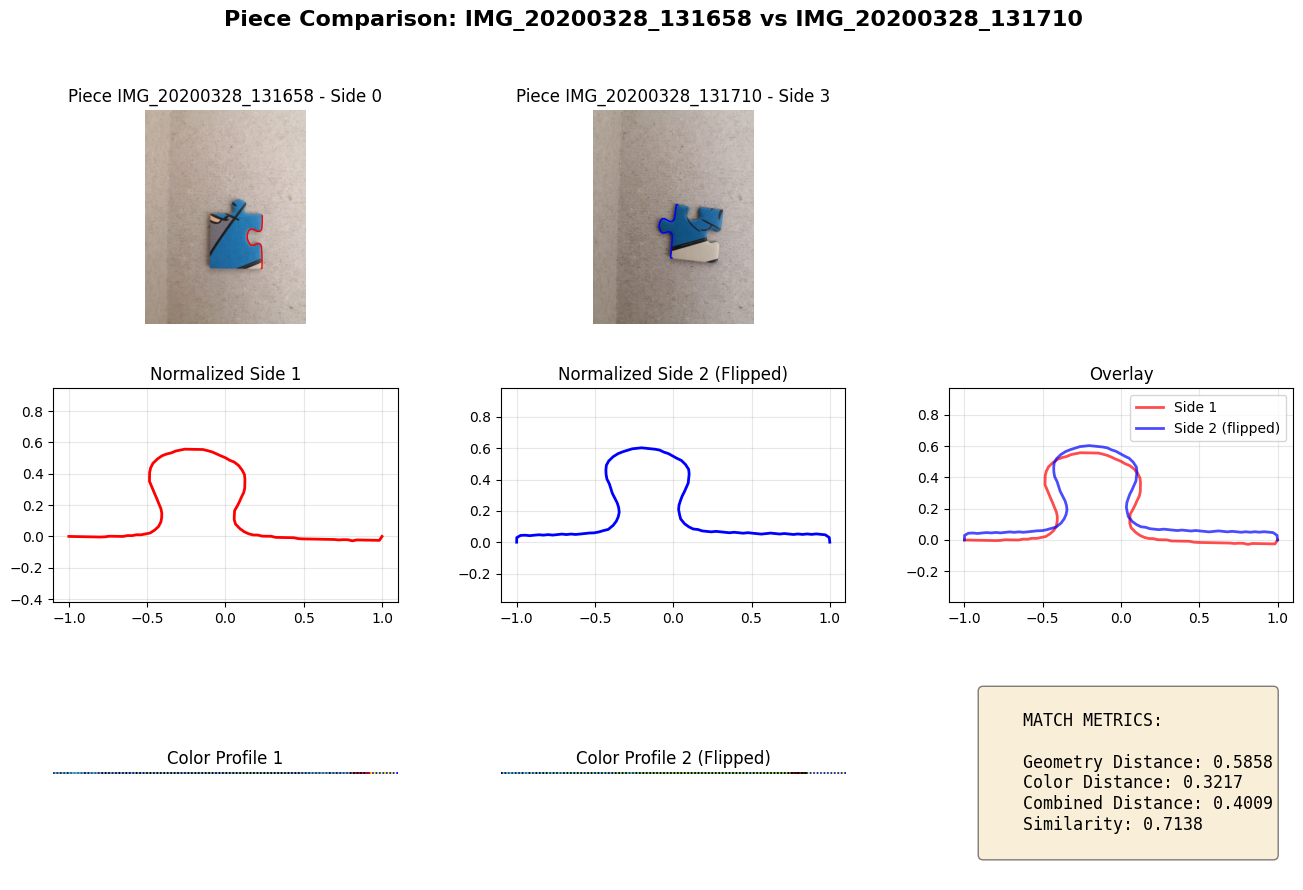


Similarity between IMG_20200328_131658 side 0 and IMG_20200328_131710 side 0: 0.7138


In [327]:
def compare_two_pieces(piece_id1, piece_id2, side_idx1, side_idx2):
    """Compare two specific sides from two pieces"""
    # Load both pieces
    img1, mask1 = load_piece(piece_id1)
    img2, mask2 = load_piece(piece_id2)
    
    # Extract features
    contour1, corners1 = extract_contour_and_corners(mask1)
    contour2, corners2 = extract_contour_and_corners(mask2)
    
    sides1 = extract_sides(contour1, corners1)
    sides2 = extract_sides(contour2, corners2)
    
    norm_side1, norm_color1 = normalize_side_with_color(sides1[side_idx1], img1, mask1)
    norm_side2, norm_color2 = normalize_side_with_color(sides2[side_idx2], img2, mask2)
    
    # Flip side2 for matching
    norm_side2_flipped = np.copy(norm_side2)
    norm_side2_flipped[:, 0] = -norm_side2_flipped[:, 0]  # Flip horizontally
    norm_side2_flipped[:, 1] = -norm_side2_flipped[:, 1]  # Flip vertically
    norm_side2_flipped = norm_side2_flipped[::-1]         # Reverse point order
    norm_color2_flipped = norm_color2[::-1]

    # Calculate distances
    geom1 = norm_side1.flatten()
    geom2 = norm_side2_flipped.flatten()
    color1 = norm_color1.flatten() 
    color2 = norm_color2_flipped.flatten() 
    
    geom_dist = distance.euclidean(geom1, geom2)
    color_dist = cosine(color1, color2)
    combined_dist = 0.3 * geom_dist + 0.7 * color_dist
    similarity = 1.0 / (1.0 + combined_dist)
    
    # Visualize
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Original images
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img1)
    ax1.plot(sides1[side_idx1][:, 0], sides1[side_idx1][:, 1], 'r-', linewidth=1)
    ax1.set_title(f"Piece {piece_id1} - Side {side_idx1}")
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(img2)
    ax2.plot(sides2[side_idx2][:, 0], sides2[side_idx2][:, 1], 'b-', linewidth=1)
    ax2.set_title(f"Piece {piece_id2} - Side {side_idx2}")
    ax2.axis('off')
    
    # Normalized geometry
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(norm_side1[:, 0], norm_side1[:, 1], 'r-', linewidth=2, label='Piece 1')
    ax3.set_title("Normalized Side 1")
    ax3.axis('equal')
    ax3.grid(True, alpha=0.3)
    
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(norm_side2_flipped[:, 0], norm_side2_flipped[:, 1], 'b-', linewidth=2, label='Piece 2 (flipped)')
    ax4.set_title("Normalized Side 2 (Flipped)")
    ax4.axis('equal')
    ax4.grid(True, alpha=0.3)
    
    # Overlay
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.plot(norm_side1[:, 0], norm_side1[:, 1], 'r-', linewidth=2, alpha=0.7, label='Side 1')
    ax5.plot(norm_side2_flipped[:, 0], norm_side2_flipped[:, 1], 'b-', linewidth=2, alpha=0.7, label='Side 2 (flipped)')
    ax5.set_title("Overlay")
    ax5.axis('equal')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Color strips
    ax6 = fig.add_subplot(gs[2, 0])
    color_strip1 = np.clip(norm_color1, 0, 1).reshape(1, -1, 3)  # clip values
    ax6.imshow(color_strip1)
    ax6.set_title("Color Profile 1")
    ax6.axis('off')
    
    ax7 = fig.add_subplot(gs[2, 1])
    color_strip2 = np.clip(norm_color2_flipped, 0, 1).reshape(1, -1, 3)  # clip values
    ax7.imshow(color_strip2)
    ax7.set_title("Color Profile 2 (Flipped)")
    ax7.axis('off')
    
    # Metrics
    ax8 = fig.add_subplot(gs[2, 2])
    ax8.axis('off')
    metrics_text = f"""
    MATCH METRICS:
    
    Geometry Distance: {geom_dist:.4f}
    Color Distance: {color_dist:.4f}
    Combined Distance: {combined_dist:.4f}
    Similarity: {similarity:.4f}
    """
    ax8.text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center',
             family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f"Piece Comparison: {piece_id1} vs {piece_id2}", fontsize=16, fontweight='bold')
    plt.show()
    
    return similarity

test_piece1 = all_images[0].stem
test_piece2 = all_images[1].stem
sim = compare_two_pieces(test_piece1, test_piece2, 0, 3)
print(f"\nSimilarity between {test_piece1} side 0 and {test_piece2} side 0: {sim:.4f}")

## 7. Analyze Best Matches for Sample Piece


Top 3 matches for IMG_20200328_131658 side 0:
Rank   Piece ID        Side   Similarity   Geom Dist    Color Dist   Type        
-------------------------------------------------------------------------------------
1      IMG_20200328_131710 3      0.7138       0.5858       0.3217       protruding  
2      IMG_20200328_133024 1      0.7062       0.5736       0.3486       protruding  
3      IMG_20200328_135124 0      0.6891       0.7682       0.3153       protruding  


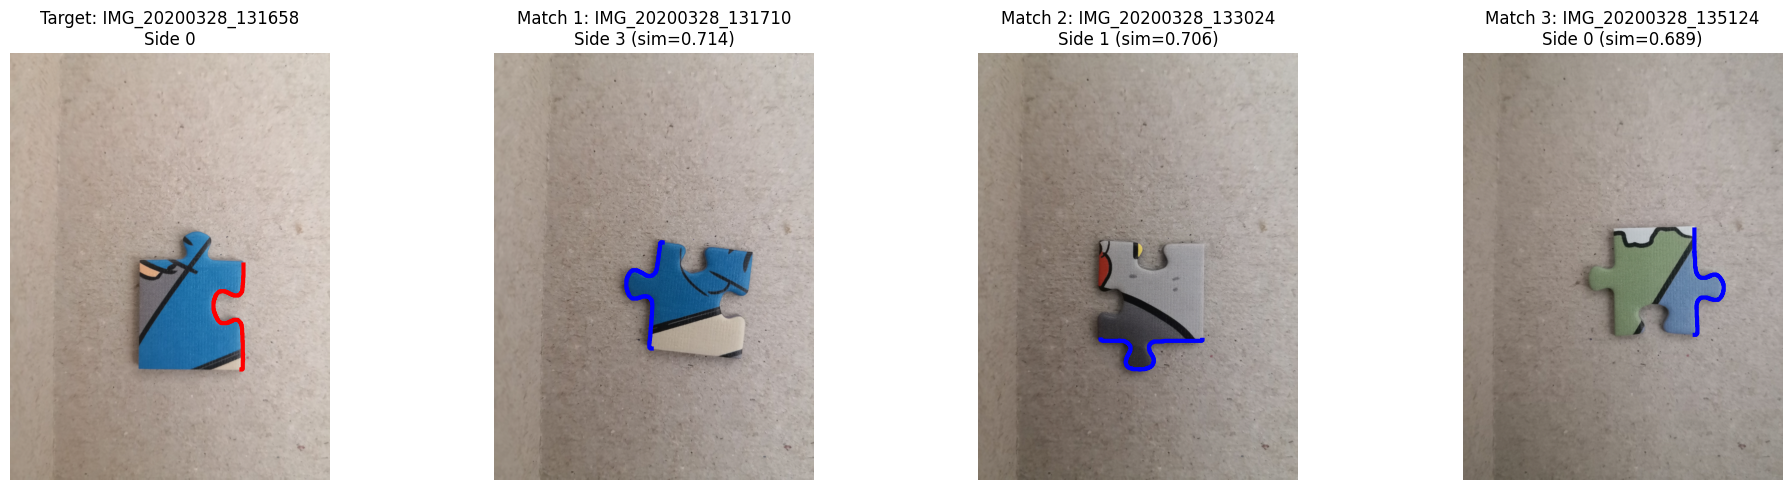

In [326]:
def find_best_matches_for_piece(target_piece_id, side_idx, top_n=3):
    """Find best matching pieces for a specific side"""
    # Load target piece
    img_target, mask_target = load_piece(target_piece_id)
    contour_target, corners_target = extract_contour_and_corners(mask_target)
    sides_target = extract_sides(contour_target, corners_target)
    norm_side_target, norm_color_target = normalize_side_with_color(sides_target[side_idx], img_target, mask_target)
    
    # Classify target side
    side_type_target = classify_side(norm_side_target)
    
    if side_type_target == 'flat':
        print(f"Side {side_idx} is flat - cannot match")
        return []
    
    # Compare against all other pieces
    matches = []
    
    for img_path in all_images:
        piece_id = img_path.stem
        if piece_id == target_piece_id:
            continue
        
        img, mask = load_piece(piece_id)
        contour, corners = extract_contour_and_corners(mask)

        sides = extract_sides(contour, corners)
        
        for test_side_idx in range(4):
            norm_side, norm_color = normalize_side_with_color(sides[test_side_idx], img, mask)
            side_type = classify_side(norm_side)
            
            # Check compatibility
            if side_type == 'flat':
                continue
            if not ((side_type_target == 'sunken' and side_type == 'protruding') or
                    (side_type_target == 'protruding' and side_type == 'sunken')):
                continue
            
            norm_side_flipped = np.copy(norm_side)
            norm_side_flipped[:, 0] = -norm_side_flipped[:, 0]  # Flip horizontally
            norm_side_flipped[:, 1] = -norm_side_flipped[:, 1]  # Flip vertically
            norm_side_flipped = norm_side_flipped[::-1]         # Reverse point order
            norm_color_flipped = norm_color[::-1]

            geom1 = norm_side_target.flatten()
            geom2 = norm_side_flipped.flatten()
            color1 = norm_color_target.flatten() 
            color2 = norm_color_flipped.flatten()

            geom_dist = distance.euclidean(geom1, geom2)
            color_dist = cosine(color1, color2) # 0 = identical, 1 = orthogonal

            combined_dist = 0.3 * geom_dist + 0.7 * color_dist
            similarity = 1.0 / (1.0 + combined_dist)
            
            matches.append({
                'piece_id': piece_id,
                'side_idx': test_side_idx,
                'similarity': similarity,
                'geom_dist': geom_dist,
                'color_dist': color_dist,
                'side_type': side_type
            })
    
    # Sort and return top N
    matches.sort(key=lambda x: x['similarity'], reverse=True)
    return matches[:top_n]

# Find best matches for sample piece
best_matches = find_best_matches_for_piece(sample_piece_id, 0, top_n=3)

print(f"\nTop 3 matches for {sample_piece_id} side 0:")
print(f"{'Rank':<6} {'Piece ID':<15} {'Side':<6} {'Similarity':<12} {'Geom Dist':<12} {'Color Dist':<12} {'Type':<12}")
print("-" * 85)
for rank, match in enumerate(best_matches, 1):
    print(f"{rank:<6} {match['piece_id']:<15} {match['side_idx']:<6} "
          f"{match['similarity']:<12.4f} {match['geom_dist']:<12.4f} "
          f"{match['color_dist']:<12.4f} {match['side_type']:<12}")

# Visualize top 3 matches
if len(best_matches) >= 3:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Target piece
    img_target, mask_target = load_piece(sample_piece_id)
    contour_target, corners_target = extract_contour_and_corners(mask_target)
    sides_target = extract_sides(contour_target, corners_target)
    
    axes[0].imshow(img_target)
    axes[0].plot(sides_target[0][:, 0], sides_target[0][:, 1], 'r-', linewidth=3)
    axes[0].set_title(f"Target: {sample_piece_id}\nSide 0")
    axes[0].axis('off')
    
    # Top 3 matches
    for i, match in enumerate(best_matches[:3]):
        img_match, mask_match = load_piece(match['piece_id'])
        contour_match, corners_match = extract_contour_and_corners(mask_match)
        sides_match = extract_sides(contour_match, corners_match)
        
        axes[i+1].imshow(img_match)
        axes[i+1].plot(sides_match[match['side_idx']][:, 0], 
                       sides_match[match['side_idx']][:, 1], 'b-', linewidth=3)
        axes[i+1].set_title(f"Match {i+1}: {match['piece_id']}\n"
                            f"Side {match['side_idx']} (sim={match['similarity']:.3f})")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

## 8. Statistics Across Dataset

In [224]:
print("\nComputing statistics across all pieces...")

piece_type_counts = {'corner': 0, 'edge': 0, 'interior': 0}
side_type_counts = {'flat': 0, 'protruding': 0, 'sunken': 0}
deviation_stats = []

for img_path in all_images:
    piece_id = img_path.stem
    img, mask = load_piece(piece_id)
    contour, corners = extract_contour_and_corners(mask)
    sides = extract_sides(contour, corners)
    
    side_types_piece = []
    for side in sides:
        norm_side, _ = normalize_side_with_color(side, img)
        side_type = classify_side(norm_side)
        side_types_piece.append(side_type)
        side_type_counts[side_type] += 1
        deviation_stats.append({'side_type': side_type})
    
    # Determine piece type
    num_flat = side_types_piece.count('flat')
    if num_flat == 0:
        piece_type_counts['interior'] += 1
    elif num_flat == 1:
        piece_type_counts['edge'] += 1
    else:
        piece_type_counts['corner'] += 1

print("\nPiece Type Distribution:")
for ptype, count in piece_type_counts.items():
    print(f"  {ptype.capitalize()}: {count}")

print("\nSide Type Distribution:")
for stype, count in side_type_counts.items():
    print(f"  {stype.capitalize()}: {count}")


Computing statistics across all pieces...

Piece Type Distribution:
  Corner: 5
  Edge: 116
  Interior: 879

Side Type Distribution:
  Flat: 126
  Protruding: 1939
  Sunken: 1935


## 9. Visualize Multiple Pieces by Type


Visualizing edge pieces...


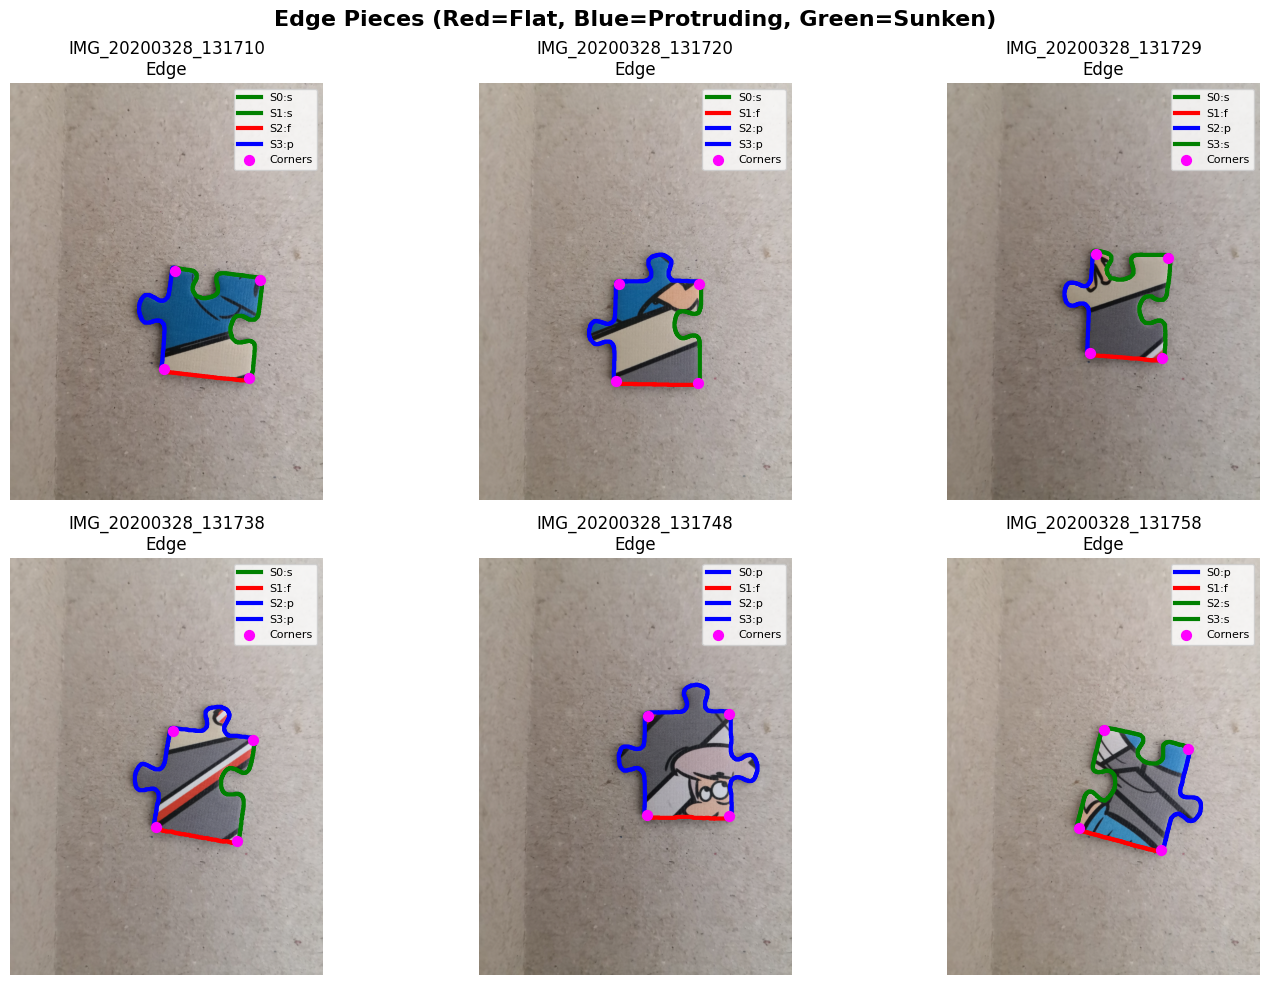


Visualizing interior pieces...


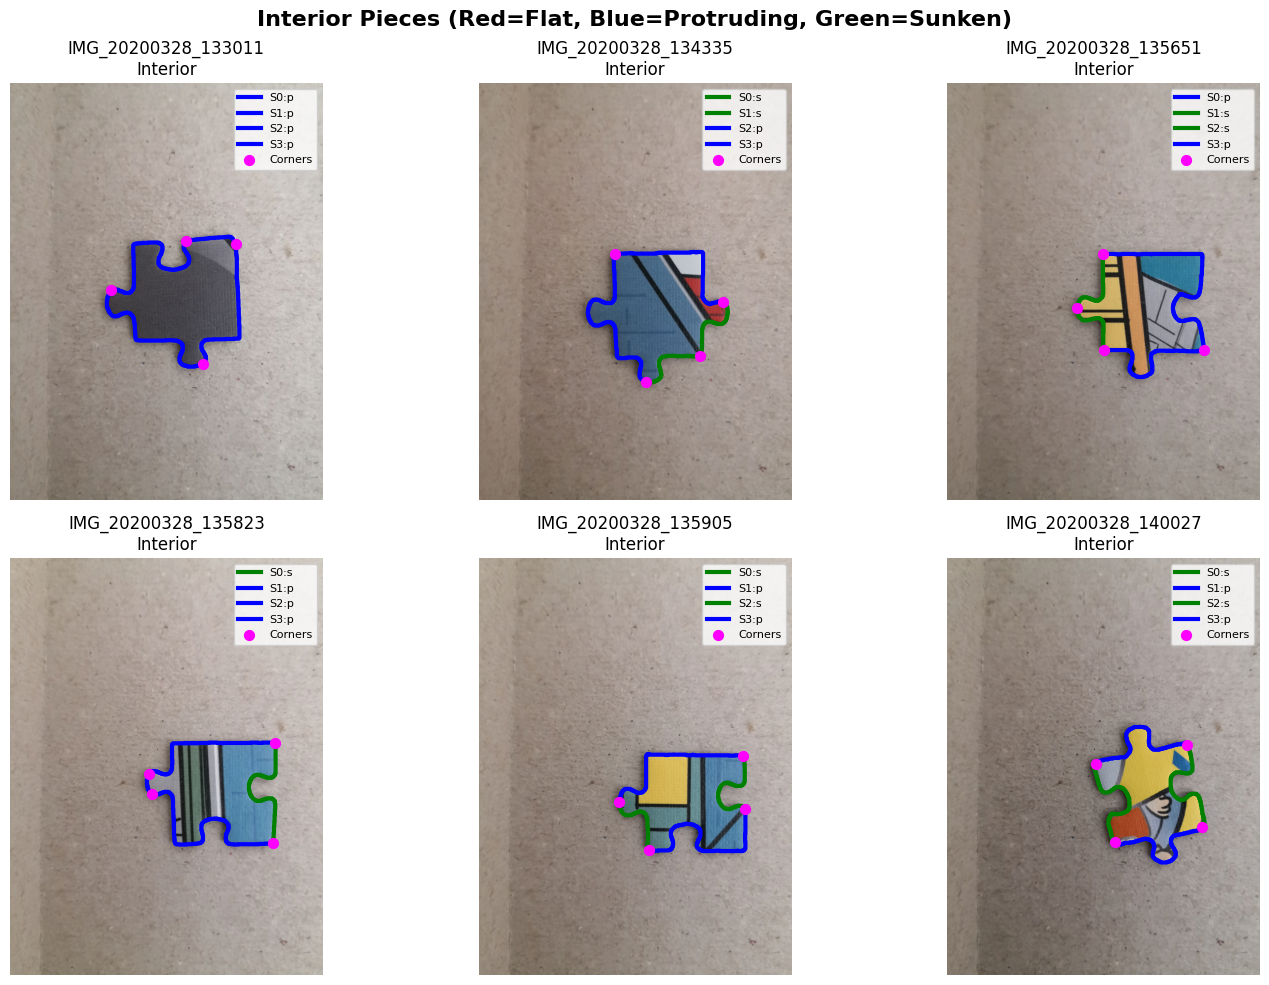

In [221]:
def visualize_pieces_by_type(piece_type, n_samples=6):
    """Visualize sample pieces of a given type"""
    samples = []
    
    for img_path in all_images:
        if len(samples) >= n_samples:
            break
        
        piece_id = img_path.stem
        img, mask = load_piece(piece_id)
        contour, corners = extract_contour_and_corners(mask)
        sides = extract_sides(contour, corners)
        
        side_types_piece = []
        for side in sides:
            norm_side, _ = normalize_side_with_color(side, img)
            side_type = classify_side(norm_side)
            side_types_piece.append(side_type)
        
        # Determine piece type
        num_flat = side_types_piece.count('flat')
        if num_flat == 0:
            ptype = 'interior'
        elif num_flat == 1:
            ptype = 'edge'
        else:
            ptype = 'corner'
        
        if ptype == piece_type:
            samples.append((piece_id, img, sides, side_types_piece, corners))
    
    if len(samples) == 0:
        print(f"No {piece_type} pieces found")
        return
    
    # Visualize
    rows = (len(samples) + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
    # Always make axes a 1D list
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for idx, (piece_id, img, sides, side_types_piece, corners) in enumerate(samples):
        ax = axes[idx]
        ax.imshow(img)
        
        # Draw sides with different colors
        colors = {'flat': 'red', 'protruding': 'blue', 'sunken': 'green'}
        for i, (side, stype) in enumerate(zip(sides, side_types_piece)):
            ax.plot(side[:, 0], side[:, 1], color=colors[stype], linewidth=3, label=f'S{i}:{stype[0]}')

        # Draw corners
        ax.scatter(corners[:, 0], corners[:, 1], c='magenta', s=50, zorder=5, marker='o', label='Corners')

        ax.set_title(f"{piece_id}\n{piece_type.capitalize()}")
        ax.legend(loc='upper right', fontsize=8)
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(len(samples), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f"{piece_type.capitalize()} Pieces (Red=Flat, Blue=Protruding, Green=Sunken)", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize samples of each type
for ptype in ['corner', 'edge', 'interior']:
    print(f"\nVisualizing {ptype} pieces...")
    visualize_pieces_by_type(ptype, n_samples=6)

## 10. Test Different Similarity Weights


Testing similarity weights on IMG_20200328_131658 vs IMG_20200328_131710:
Base geometry distance: 10.7293
Base color distance: 0.1072

Geom Weight  Color Weight Similarity   Combined Dist  
-------------------------------------------------------
1.0          0.0          0.0853       10.7293        
0.8          0.2          0.1041       8.6049         
0.6          0.4          0.1337       6.4805         
0.5          0.5          0.1558       5.4183         
0.4          0.6          0.1867       4.3561         
0.2          0.8          0.3094       2.2316         
0.0          1.0          0.9032       0.1072         


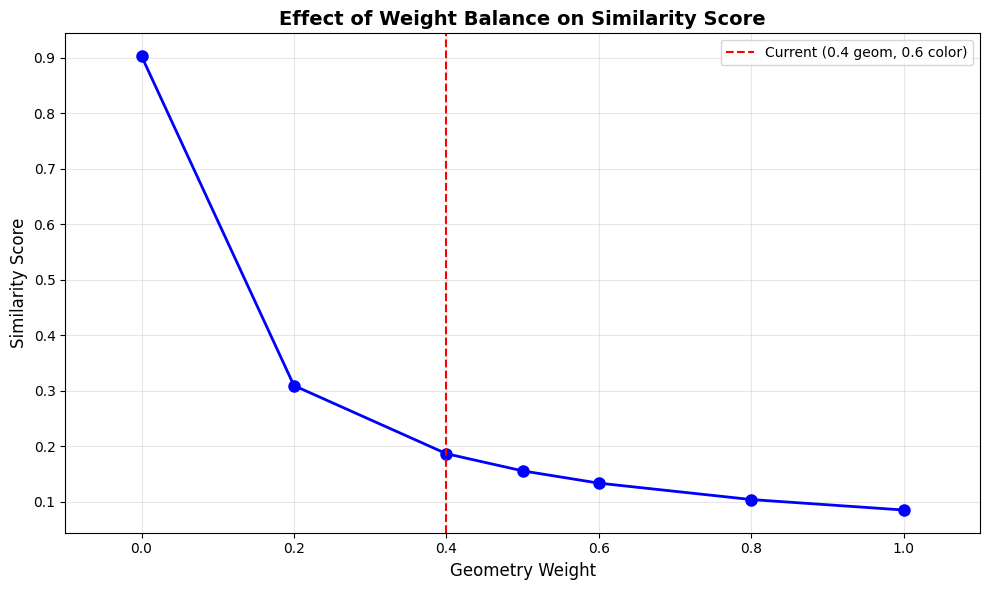

In [321]:
def test_similarity_weights(piece_id1, side_idx1, piece_id2, side_idx2, weights_list):
    """Test different weight combinations for geometry vs color"""
    # Load and process both pieces
    img1, mask1 = load_piece(piece_id1)
    img2, mask2 = load_piece(piece_id2)
    
    contour1, corners1 = extract_contour_and_corners(mask1)
    contour2, corners2 = extract_contour_and_corners(mask2)
    
    sides1 = extract_sides(contour1, corners1)
    sides2 = extract_sides(contour2, corners2)
    
    norm_side1, norm_color1 = normalize_side_with_color(sides1[side_idx1], img1, mask1)
    norm_side2, norm_color2 = normalize_side_with_color(sides2[side_idx2], img2, mask2)
    
    # Flip side2
    norm_side2_flipped = norm_side2[::-1]
    norm_color2_flipped = norm_color2[::-1]
    
    # Calculate base distances
    geom1 = norm_side1.flatten()
    geom2 = norm_side2_flipped.flatten()
    color1 = norm_color1.flatten() / 255.0
    color2 = norm_color2_flipped.flatten() / 255.0
    
    geom_dist = distance.euclidean(geom1, geom2)
    color_dist = distance.euclidean(color1, color2)
    
    # Test different weights
    results = []
    for geom_weight, color_weight in weights_list:
        combined_dist = geom_weight * geom_dist + color_weight * color_dist
        similarity = 1.0 / (1.0 + combined_dist)
        results.append({
            'geom_weight': geom_weight,
            'color_weight': color_weight,
            'similarity': similarity,
            'combined_dist': combined_dist
        })
    
    return results, geom_dist, color_dist

# Test different weight combinations
if len(all_images) > 1:
    test_piece1 = all_images[0].stem
    test_piece2 = all_images[1].stem
    
    weights_to_test = [
        (1.0, 0.0),  # Geometry only
        (0.8, 0.2),
        (0.6, 0.4),
        (0.5, 0.5),  # Equal
        (0.4, 0.6),  # Current
        (0.2, 0.8),
        (0.0, 1.0),  # Color only
    ]
    
    results, geom_d, color_d = test_similarity_weights(test_piece1, 0, test_piece2, 0, weights_to_test)
    
    print(f"\nTesting similarity weights on {test_piece1} vs {test_piece2}:")
    print(f"Base geometry distance: {geom_d:.4f}")
    print(f"Base color distance: {color_d:.4f}")
    print(f"\n{'Geom Weight':<12} {'Color Weight':<12} {'Similarity':<12} {'Combined Dist':<15}")
    print("-" * 55)
    for r in results:
        print(f"{r['geom_weight']:<12.1f} {r['color_weight']:<12.1f} {r['similarity']:<12.4f} {r['combined_dist']:<15.4f}")
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    geom_weights = [r['geom_weight'] for r in results]
    similarities = [r['similarity'] for r in results]
    
    ax.plot(geom_weights, similarities, 'bo-', linewidth=2, markersize=8)
    ax.set_xlabel('Geometry Weight', fontsize=12)
    ax.set_ylabel('Similarity Score', fontsize=12)
    ax.set_title('Effect of Weight Balance on Similarity Score', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.1, 1.1)
    
    # Add vertical line at current setting
    ax.axvline(x=0.4, color='r', linestyle='--', label='Current (0.4 geom, 0.6 color)')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

## 11. Analyze Match Quality Distribution


Sampling random matches to analyze distribution...

Random Match Statistics (n=94):
  Similarity:     mean=0.1801, std=0.0103, max=0.1999
  Geom Distance:  mean=11.2821, std=0.7843, min=9.8733
  Color Distance: mean=0.0966, std=0.0111, min=0.0382


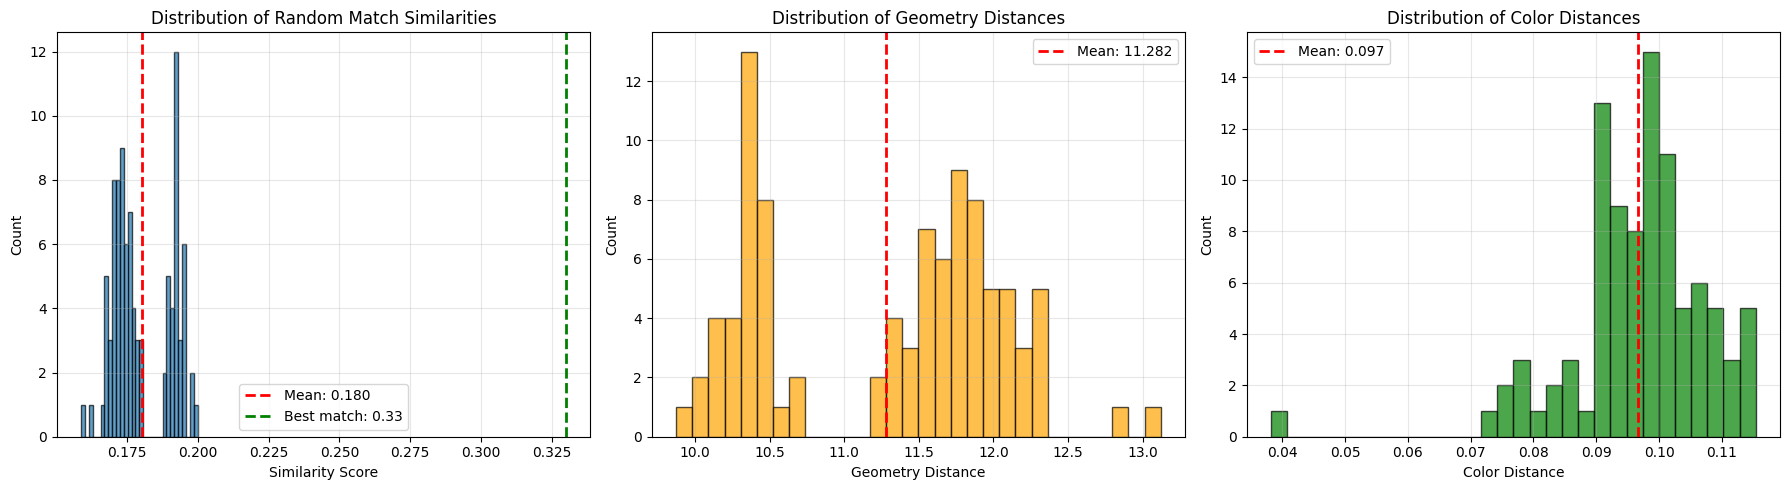

In [325]:
def sample_random_matches(n_samples=100):
    """Sample random piece pairs and compute their similarity"""
    
    similarities = []
    geom_dists = []
    color_dists = []
    
    piece_list = [p.stem for p in all_images]
    
    for _ in range(n_samples):
        # Random pieces and sides
        p1, p2 = random.sample(piece_list, 2)
        s1, s2 = random.randint(0, 3), random.randint(0, 3)
        
        try:
            # Load and process
            img1, mask1 = load_piece(p1)
            img2, mask2 = load_piece(p2)
            
            contour1, corners1 = extract_contour_and_corners(mask1)
            contour2, corners2 = extract_contour_and_corners(mask2)
            
            sides1 = extract_sides(contour1, corners1)
            sides2 = extract_sides(contour2, corners2)
            
            norm_side1, norm_color1 = normalize_side_with_color(sides1[s1], img1, mask1)
            norm_side2, norm_color2 = normalize_side_with_color(sides2[s2], img2, mask2)
            
            # Check types
            type1 = classify_side(norm_side1)
            type2 = classify_side(norm_side2)
            
            # Skip flat sides
            if type1 == 'flat' or type2 == 'flat':
                continue
            
            # Calculate similarity
            norm_side2_flipped = norm_side2[::-1]
            norm_color2_flipped = norm_color2[::-1]
            
            geom1 = norm_side1.flatten()
            geom2 = norm_side2_flipped.flatten()
            color1 = norm_color1.flatten() / 255.0
            color2 = norm_color2_flipped.flatten() / 255.0
            
            geom_dist = distance.euclidean(geom1, geom2)
            color_dist = distance.euclidean(color1, color2)
            combined_dist = 0.4 * geom_dist + 0.6 * color_dist
            similarity = 1.0 / (1.0 + combined_dist)
            
            similarities.append(similarity)
            geom_dists.append(geom_dist)
            color_dists.append(color_dist)
            
        except Exception as e:
            continue
    
    return similarities, geom_dists, color_dists

print("\nSampling random matches to analyze distribution...")
sims, geoms, colors = sample_random_matches(n_samples=100)

print(f"\nRandom Match Statistics (n={len(sims)}):")
print(f"  Similarity:     mean={np.mean(sims):.4f}, std={np.std(sims):.4f}, max={np.max(sims):.4f}")
print(f"  Geom Distance:  mean={np.mean(geoms):.4f}, std={np.std(geoms):.4f}, min={np.min(geoms):.4f}")
print(f"  Color Distance: mean={np.mean(colors):.4f}, std={np.std(colors):.4f}, min={np.min(colors):.4f}")

# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(sims, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=np.mean(sims), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sims):.3f}')
axes[0].axvline(x=0.33, color='g', linestyle='--', linewidth=2, label='Best match: 0.33')
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Random Match Similarities')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(geoms, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=np.mean(geoms), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(geoms):.3f}')
axes[1].set_xlabel('Geometry Distance')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Geometry Distances')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].hist(colors, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[2].axvline(x=np.mean(colors), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(colors):.3f}')
axes[2].set_xlabel('Color Distance')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Color Distances')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()